In [1]:
import numpy as np
import pandas as pd 
import os
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler,MaxAbsScaler,RobustScaler, QuantileTransformer,PowerTransformer
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, explained_variance_score
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, KFold
import warnings
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor



# Reset warning filters (optional)
warnings.resetwarnings()
warnings.filterwarnings('ignore')
# Better display the output
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 500)


/Users/urisegman/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


# Pull the Data, and load 

In [43]:
demand_df = pd.read_csv('demand.csv')
print(f'demand df shape is {demand_df.shape}')
fulfilment_df = pd.read_csv('fulfilment_center_info.csv')
print(f'fullfilment df shape is {fulfilment_df.shape}')
meal_df = pd.read_csv('meal_info.csv')
print(f'meal df shape is {meal_df.shape}')


demand df shape is (456548, 9)
fullfilment df shape is (77, 5)
meal df shape is (51, 3)


# Create geographic continous features

In [44]:
fulfilment_df['region_center_count'] = fulfilment_df.groupby('region_code')['center_id'].transform('count')
fulfilment_df['city_center_count'] = fulfilment_df.groupby('city_code')['center_id'].transform('count')
fulfilment_df['region_city_count'] = fulfilment_df.groupby('region_code')['city_code'].transform('nunique')


In [45]:
fulfilment_df


,center_id,city_code,region_code,center_type,op_area,region_center_count,city_center_count,region_city_count
0,11,679,56,TYPE_A,3.7,30,1,16
1,13,590,56,TYPE_B,6.7,30,9,16
2,124,590,56,TYPE_C,4.0,30,9,16
3,66,648,34,TYPE_A,4.1,21,1,12
4,94,632,34,TYPE_C,3.6,21,1,12
5,64,553,77,TYPE_A,4.4,17,1,16
6,129,593,77,TYPE_A,3.9,17,2,16
7,139,693,34,TYPE_C,2.8,21,1,12
8,88,526,34,TYPE_A,4.1,21,8,12
9,143,562,77,TYPE_B,3.8,17,1,16


# Create the final data

In [46]:
combined_df = pd.merge(demand_df, fulfilment_df, on='center_id', how='left')
combined_df = pd.merge(combined_df, meal_df,  on='meal_id', how='left')


In [47]:
number_sold_at = combined_df.groupby('meal_id').agg(
    num_centers_sold_at=('center_id', 'nunique'),
    average_num_orders=('num_orders', 'mean'),
).reset_index()
combined_df = pd.merge(combined_df, number_sold_at,  on='meal_id', how='left')
combined_df

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,city_code,region_code,center_type,op_area,region_center_count,city_center_count,region_city_count,category,cuisine,num_centers_sold_at,average_num_orders
0,1379560,1,55,1885,136.83,152.29,0,0,177,647,56,TYPE_C,2.0,30,2,16,Beverages,Thai,77,752.456365
1,1466964,1,55,1993,136.83,135.83,0,0,270,647,56,TYPE_C,2.0,30,2,16,Beverages,Thai,77,598.853544
2,1346989,1,55,2539,134.86,135.86,0,0,189,647,56,TYPE_C,2.0,30,2,16,Beverages,Thai,77,309.494594
3,1338232,1,55,2139,339.50,437.53,0,0,54,647,56,TYPE_C,2.0,30,2,16,Beverages,Indian,76,42.813462
4,1448490,1,55,2631,243.50,242.50,0,0,40,647,56,TYPE_C,2.0,30,2,16,Beverages,Indian,77,104.239051
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
456543,1271326,145,61,1543,484.09,484.09,0,0,68,473,77,TYPE_A,4.5,17,1,16,Desert,Indian,77,77.279894
456544,1062036,145,61,2304,482.09,482.09,0,0,42,473,77,TYPE_A,4.5,17,1,16,Desert,Indian,77,62.978297
456545,1110849,145,61,2664,237.68,321.07,0,0,501,473,77,TYPE_A,4.5,17,1,16,Salad,Italian,77,395.900944
456546,1147725,145,61,2569,243.50,313.34,0,0,729,473,77,TYPE_A,4.5,17,1,16,Salad,Italian,77,352.510731


In [51]:
to_dummy = ['category','cuisine','center_type']
dummy_dfs = []

for column in to_dummy:
    dummy_df = pd.get_dummies(combined_df[column], prefix=column)
    dummy_dfs.append(dummy_df)

# Concatenate the original DataFrame with the dummy-encoded DataFrames
combined_df = pd.concat([combined_df] + dummy_dfs, axis=1)

# Drop the original columns if desired
combined_df = combined_df.drop(to_dummy, axis=1)


[1, 2, 3, 4, 5, 6, 7, 8, 9]

In [59]:

combined_df = combined_df.sort_values(by=['center_id','meal_id', 'week'])

for prev_week in range(1,6):
        if prev_week == 0:
            continue
        

        combined_df[f'previous_week{prev_week}_orders'] = combined_df.groupby('meal_id')['num_orders'].shift(prev_week)



In [61]:
combined_df.to_csv('ready_df_for_hyperparameter_checks.csv')

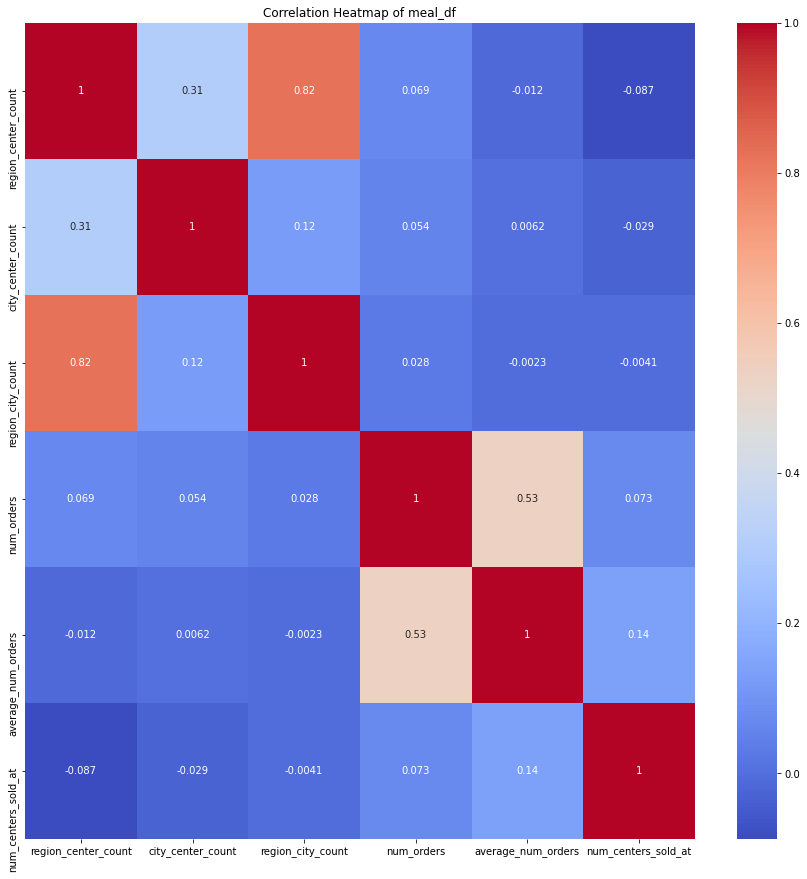

In [48]:
plt.figure(figsize=(15, 15))
sns.heatmap(combined_df[['region_center_count','city_center_count','region_city_count','num_orders','average_num_orders','num_centers_sold_at']].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap of meal_df')
plt.show()

In [19]:
combined_df.groupby(['meal_id','center_id'])

In [20]:
combined_df

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,city_code,region_code,center_type,op_area,region_center_count,city_center_count,region_city_count,category,cuisine,num_centers_sold_at_x,average_num_orders_x,num_centers_sold_at_y,average_num_orders_y
0,1379560,1,55,1885,136.83,152.29,0,0,177,647,56,TYPE_C,2.0,30,2,16,Beverages,Thai,77,752.456365,77,752.456365
1,1466964,1,55,1993,136.83,135.83,0,0,270,647,56,TYPE_C,2.0,30,2,16,Beverages,Thai,77,598.853544,77,598.853544
2,1346989,1,55,2539,134.86,135.86,0,0,189,647,56,TYPE_C,2.0,30,2,16,Beverages,Thai,77,309.494594,77,309.494594
3,1338232,1,55,2139,339.50,437.53,0,0,54,647,56,TYPE_C,2.0,30,2,16,Beverages,Indian,76,42.813462,76,42.813462
4,1448490,1,55,2631,243.50,242.50,0,0,40,647,56,TYPE_C,2.0,30,2,16,Beverages,Indian,77,104.239051,77,104.239051
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
456543,1271326,145,61,1543,484.09,484.09,0,0,68,473,77,TYPE_A,4.5,17,1,16,Desert,Indian,77,77.279894,77,77.279894
456544,1062036,145,61,2304,482.09,482.09,0,0,42,473,77,TYPE_A,4.5,17,1,16,Desert,Indian,77,62.978297,77,62.978297
456545,1110849,145,61,2664,237.68,321.07,0,0,501,473,77,TYPE_A,4.5,17,1,16,Salad,Italian,77,395.900944,77,395.900944
456546,1147725,145,61,2569,243.50,313.34,0,0,729,473,77,TYPE_A,4.5,17,1,16,Salad,Italian,77,352.510731,77,352.510731


In [21]:
# First, ensure your data is sorted by 'id' and 'week'
combined_df = combined_df.sort_values(by=['center_id','meal_id', 'week'])



In [22]:
combined_df

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,city_code,region_code,center_type,op_area,region_center_count,city_center_count,region_city_count,category,cuisine,num_centers_sold_at_x,average_num_orders_x,num_centers_sold_at_y,average_num_orders_y
2370,1436842,1,10,1062,181.39,181.39,0,0,865,590,56,TYPE_B,6.3,30,9,16,Beverages,Italian,77,423.165574,77,423.165574
5273,1205013,2,10,1062,183.36,182.36,0,0,782,590,56,TYPE_B,6.3,30,9,16,Beverages,Italian,77,423.165574,77,423.165574
8175,1447751,3,10,1062,184.36,182.36,0,0,851,590,56,TYPE_B,6.3,30,9,16,Beverages,Italian,77,423.165574,77,423.165574
11064,1014968,4,10,1062,182.36,183.36,0,0,1202,590,56,TYPE_B,6.3,30,9,16,Beverages,Italian,77,423.165574,77,423.165574
13918,1003563,5,10,1062,183.39,181.39,0,0,958,590,56,TYPE_B,6.3,30,9,16,Beverages,Italian,77,423.165574,77,423.165574
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
345410,1255251,112,186,2956,583.03,581.03,0,0,82,649,34,TYPE_A,3.4,21,1,12,Fish,Continental,53,92.518831,53,92.518831
348601,1436164,113,186,2956,583.03,582.03,0,0,40,649,34,TYPE_A,3.4,21,1,12,Fish,Continental,53,92.518831,53,92.518831
351905,1000576,114,186,2956,583.03,581.03,0,0,27,649,34,TYPE_A,3.4,21,1,12,Fish,Continental,53,92.518831,53,92.518831
355206,1429037,115,186,2956,581.03,583.03,0,0,15,649,34,TYPE_A,3.4,21,1,12,Fish,Continental,53,92.518831,53,92.518831


In [23]:
combined_df['price_difference'] = combined_df['checkout_price'] - combined_df['base_price']

In [24]:
remove_when_split_of = {
    'meal_id': ['region_code','city_code','center_id'],
    'region_code' : ['city_code','center_id','meal_id'],
    'city_code' : ['region_code','center_id','meal_id'],
    'center_id': ['region_code','city_code','meal_id'],
    None: ['region_code','city_code','center_id','meal_id'],
    'category': ['region_code','city_code','center_id','meal_id'],
    'cuisine': ['region_code','city_code','center_id','meal_id'],
    'center_type' : ['region_code','city_code','center_id','meal_id']
                       }

In [25]:
def create_backtrack_columns(df, backwards_weeks: list, features_to_collect_backwards = ['num_orders']):
    for prev_week in backwards_weeks:
        if prev_week == 0:
            continue
            
        for feature_to_collect in features_to_collect_backwards:
            df[f'previous_week{prev_week}_{feature_to_collect}'] = df.groupby('meal_id')[feature_to_collect].shift(prev_week)
    return df

In [26]:
def dummyfy(df, to_dummy=None):
    if not to_dummy:
        to_dummy = ['category','cuisine','center_type','region_code']
    dummy_dfs = []
    for column in to_dummy:
        dummy_df = pd.get_dummies(df[column], prefix=column)
        dummy_dfs.append(dummy_df)

    # Concatenate the original DataFrame with the dummy-encoded DataFrames
    df = pd.concat([df] + dummy_dfs, axis=1)

    # Drop the original columns if desired
    df = df.drop(to_dummy, axis=1)
    
    
    return df

In [27]:
max(list(range(1,6)))

5

In [28]:
def prepare_df(df, split_value, columns_to_drop, list_of_weeks_to_backtrack = list(range(1,6)), features_to_backtrack =  ['num_orders']):
    to_dummy = ['category','cuisine','center_type']
    cols_to_drop = ['id','week'] + columns_to_drop
   
    if split_value in to_dummy:
        to_dummy.remove(split_value)
        
    df = dummyfy(df,to_dummy)
    df = create_backtrack_columns(df, list_of_weeks_to_backtrack, features_to_backtrack)
    
    # drops al Na for products that are in their intial weeks of selling
    df = df.dropna()

    ### split
    if not split_value:
        df = df.drop(columns = cols_to_drop)
        return [df]
    
    list_of_dfs = []  # empty list to hold dataframes
    for category, group_df in df.groupby(split_value):
        group_df = group_df.drop(columns = cols_to_drop)
        list_of_dfs.append(group_df)

    return list_of_dfs
    

  

In [29]:
def run_a_k_fold_model_test(X, y, model):
    k = 5

    # Initialize a KFold object
    kf = KFold(n_splits=k, random_state=42, shuffle=True)
    
    types_of_scalars = [RobustScaler, QuantileTransformer, MinMaxScaler]
    roi_d = {}
    for scale in types_of_scalars:
        print(f'####RUNNING k-fold TEST ON {scale.__name__}######')
        X_scaled = scale().fit_transform(X)
        X_scaled = pd.DataFrame(X_scaled, columns=X.columns)   

        MAE = 0
        MSE = 0
        r2 = 0
        for train_index, test_index in kf.split(X_scaled):
            X_train, X_test = X_scaled.iloc[train_index], X_scaled.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]

            
            model_kf = model()
            model_kf.fit(X_train, y_train)
            y_pred = model_kf.predict(X_test)
            r2 += r2_score(y_test,y_pred)
            MAE += mean_absolute_error(y_test,y_pred)
            MSE += mean_squared_error(y_test,y_pred)
            

        
        print("r^2: ", r2/k, " MSE: ", MSE/k, " MAE: ", MAE/k)
        
    return r2/k, MSE/k, MAE/k

In [30]:
def run_a_model_test(X, y, model, scalar=RobustScaler):
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Initialize a scaler
    scaler = scalar()

    # Scale the data
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # model must be Initialized in function call to fit the model
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)

    # Calculate metrics
    r2 = r2_score(y_test, y_pred)
    MAE = mean_absolute_error(y_test, y_pred)
    MSE = mean_squared_error(y_test, y_pred)

    # Return the metrics
    return r2, MAE, MSE, y_pred

In [31]:
remove_when_split_of # testing combinations

{'meal_id': ['region_code', 'city_code', 'center_id'],
 'region_code': ['city_code', 'center_id', 'meal_id'],
 'city_code': ['region_code', 'center_id', 'meal_id'],
 'center_id': ['region_code', 'city_code', 'meal_id'],
 None: ['region_code', 'city_code', 'center_id', 'meal_id'],
 'category': ['region_code', 'city_code', 'center_id', 'meal_id'],
 'cuisine': ['region_code', 'city_code', 'center_id', 'meal_id'],
 'center_type': ['region_code', 'city_code', 'center_id', 'meal_id']}

# Running a single test


In [210]:
remove_when_split_of[None]

['region_code', 'city_code', 'center_id', 'meal_id']

In [33]:
entire_df = prepare_df(combined_df,None, remove_when_split_of[None])
entire_df = entire_df[0]


In [34]:
X, FINAL_TEST_X, Y, FINAL_TEST_y = train_test_split(entire_df, entire_df['num_orders'], test_size=0.2, random_state=42)
X = X.drop(columns = 'num_orders')


In [35]:
r2, MSE, MAE = run_a_model_test(X,Y,LinearRegression)

TypeError: fit() missing 1 required positional argument: 'y'

In [ ]:
np.mean([1,2,3,4])

In [296]:
models = [LinearRegression(),AdaBoostRegressor(n_estimators=500, learning_rate=1, loss='linear',random_state=42),RandomForestRegressor(n_estimators=100, random_state=42)]



In [290]:
type(models[0]).__name__

'LinearRegression'

In [297]:
# for col_to_split, cols_to_remove in remove_when_split_of.items():
split_on = 'meal_id'
df_lists = prepare_df(combined_df,split_on, remove_when_split_of[split_on])
results = {}

for model in models:
    list_r2, list_MAE, list_MSE = [],[],[] 
    print(f'testing {type(model).__name__}')
    for subset_df in df_lists:
        individual_results = {}
        individual_results['length'] = len(subset_df)
        subset_name =  subset_df[split_on].unique()

        subset_df = subset_df.drop(columns = split_on)
        X, FINAL_TEST_X, Y, FINAL_TEST_y = train_test_split(subset_df, subset_df['num_orders'], test_size=0.2, random_state=42)
        X = X.drop(columns = 'num_orders')
        r2, MAE, MSE, y_pred = run_a_model_test(X,Y, model)

        individual_results['r2'] = r2
        individual_results['MAE'] = MAE
        individual_results['MSE'] = MSE 

        list_r2.append(r2)
        list_MAE.append(MAE)
        list_MSE.append(MSE)
        results[f"{type(model).__name__}_{subset_name[0]}"] = individual_results
    
    print(f'the split on {split_on} scored: av_R2 {np.mean(list_r2)}, av_mse {np.mean(list_MSE)},av_mAE {np.mean(list_MAE)} ')
    

testing LinearRegression
the split on meal_id scored: av_R2 0.5913099606384282, av_mse 36629.51297803767,av_mAE 79.8602339190132 
testing AdaBoostRegressor
the split on meal_id scored: av_R2 0.04831714263287041, av_mse 113860.30479422618,av_mAE 191.60885374797948 
testing RandomForestRegressor
the split on meal_id scored: av_R2 0.6604697627861844, av_mse 23156.255344746827,av_mAE 67.04690937514869 


In [32]:
# for col_to_split, cols_to_remove in remove_when_split_of.items():
split_on = 'center_id'
df_lists = prepare_df(combined_df,split_on, remove_when_split_of[split_on])
list_r2, list_MAE, list_MSE = [],[],[] 
for subset_df in df_lists:
    individual_results = {}
    individual_results['length'] = len(subset_df)
    subset_name =  subset_df[split_on].unique()
    
    subset_df.drop(columns = split_on)
    X, FINAL_TEST_X, Y, FINAL_TEST_y = train_test_split(subset_df, subset_df['num_orders'], test_size=0.2, random_state=42)
    X = X.drop(columns = 'num_orders')
    r2, MAE, MSE, y_pred = run_a_model_test(X,Y, LinearRegression)
    
    individual_results['r2'] = r2
    individual_results['MAE'] = MAE
    individual_results['MSE'] = MSE 
    
    list_r2.append(r2)
    list_MAE.append(MAE)
    list_MSE.append(MSE)
    results[subset_name[0]] = individual_results
    
print(f'the split on {split_on} scored: av_R2 {np.mean(list_r2)}, av_mse {np.mean(list_MSE)},av_mAE {np.mean(list_MAE)} ')
    

TypeError: fit() missing 1 required positional argument: 'y'

In [270]:
# for col_to_split, cols_to_remove in remove_when_split_of.items():
split_on = 'region_code'
df_lists = prepare_df(combined_df,split_on, remove_when_split_of[split_on])
list_r2, list_MAE, list_MSE = [],[],[] 
for subset_df in df_lists:
    individual_results = {}
    individual_results['length'] = len(subset_df)
    subset_name =  subset_df[split_on].unique()
    
    subset_df = subset_df.drop(columns = split_on)
    X, FINAL_TEST_X, Y, FINAL_TEST_y = train_test_split(subset_df, subset_df['num_orders'], test_size=0.2, random_state=42)
    X = X.drop(columns = 'num_orders')
    r2, MAE, MSE, y_pred = run_a_model_test(X,Y, LinearRegression)
    
    individual_results['r2'] = r2
    individual_results['MAE'] = MAE
    individual_results['MSE'] = MSE 
    
    list_r2.append(r2)
    list_MAE.append(MAE)
    list_MSE.append(MSE)
    results[subset_name[0]] = individual_results
    
print(f'the split on {split_on} scored: av_R2 {np.mean(list_r2)}, av_mse {np.mean(list_MSE)},av_mAE {np.mean(list_MAE)} ')
    

the split on region_code scored: av_R2 0.5962495686315386, av_mse 66069.01148690349,av_mAE 108.4534043732385 


In [271]:
# for col_to_split, cols_to_remove in remove_when_split_of.items():
split_on = 'city_code'
df_lists = prepare_df(combined_df,split_on, remove_when_split_of[split_on])
list_r2, list_MAE, list_MSE = [],[],[] 
for subset_df in df_lists:
    individual_results = {}
    individual_results['length'] = len(subset_df)
    subset_name =  subset_df[split_on].unique()
    
    subset_df = subset_df.drop(columns = split_on)
    X, FINAL_TEST_X, Y, FINAL_TEST_y = train_test_split(subset_df, subset_df['num_orders'], test_size=0.2, random_state=42)
    X = X.drop(columns = 'num_orders')
    r2, MAE, MSE, y_pred = run_a_model_test(X,Y, LinearRegression)
    
    individual_results['r2'] = r2
    individual_results['MAE'] = MAE
    individual_results['MSE'] = MSE 
    
    list_r2.append(r2)
    list_MAE.append(MAE)
    list_MSE.append(MSE)
    results[subset_name[0]] = individual_results
    
print(f'the split on {split_on} scored: av_R2 {np.mean(list_r2)}, av_mse {np.mean(list_MSE)},av_mAE {np.mean(list_MAE)} ')
    

the split on city_code scored: av_R2 0.6092945137032056, av_mse 46139.41415823356,av_mAE 101.03885076590454 


In [258]:
# for col_to_split, cols_to_remove in remove_when_split_of.items():
split_on = None
df_lists = prepare_df(combined_df,split_on, remove_when_split_of[split_on])
list_r2, list_MAE, list_MSE = [],[],[] 
for subset_df in df_lists:
    individual_results = {}
    individual_results['length'] = len(subset_df)
    subset_name =  None
    
    X, FINAL_TEST_X, Y, FINAL_TEST_y = train_test_split(subset_df, subset_df['num_orders'], test_size=0.2, random_state=42)
    X = X.drop(columns = 'num_orders')
    r2, MAE, MSE, y_pred = run_a_model_test(X,Y, LinearRegression)
    
    individual_results['r2'] = r2
    individual_results['MAE'] = MAE
    individual_results['MSE'] = MSE 
    
    list_r2.append(r2)
    list_MAE.append(MAE)
    list_MSE.append(MSE)
    results[None] = individual_results
    
print(f'the split on {split_on} scored: av_R2 {np.mean(list_r2)}, av_mse {np.mean(list_MSE)},av_mAE {np.mean(list_MAE)} ')
    

the split on None scored: av_R2 0.6087406200157548, av_mse 59831.40986484164,av_mAE 112.5201043369022 


In [273]:
# for col_to_split, cols_to_remove in remove_when_split_of.items():
split_on = 'category'
df_lists = prepare_df(combined_df,split_on, remove_when_split_of[split_on])
list_r2, list_MAE, list_MSE = [],[],[] 
for subset_df in df_lists:
    individual_results = {}
    individual_results['length'] = len(subset_df)
    subset_name =  subset_df[split_on].unique()
    
    subset_df = subset_df.drop(columns = split_on)
    X, FINAL_TEST_X, Y, FINAL_TEST_y = train_test_split(subset_df, subset_df['num_orders'], test_size=0.2, random_state=42)
    X = X.drop(columns = 'num_orders')
    r2, MAE, MSE, y_pred = run_a_model_test(X,Y, LinearRegression)
    
    individual_results['r2'] = r2
    individual_results['MAE'] = MAE
    individual_results['MSE'] = MSE 
    
    list_r2.append(r2)
    list_MAE.append(MAE)
    list_MSE.append(MSE)
    results[subset_name[0]] = individual_results
    
print(f'the split on {split_on} scored: av_R2 {np.mean(list_r2)}, av_mse {np.mean(list_MSE)},av_mAE {np.mean(list_MAE)} ')
    

the split on category scored: av_R2 0.5870097961215555, av_mse 41600.128423070695,av_mAE 83.48017486023903 


In [274]:
# for col_to_split, cols_to_remove in remove_when_split_of.items():
split_on = 'cuisine'
df_lists = prepare_df(combined_df,split_on, remove_when_split_of[split_on])
list_r2, list_MAE, list_MSE = [],[],[] 
for subset_df in df_lists:
    individual_results = {}
    individual_results['length'] = len(subset_df)
    subset_name =  subset_df[split_on].unique()
    
    subset_df = subset_df.drop(columns = split_on)
    X, FINAL_TEST_X, Y, FINAL_TEST_y = train_test_split(subset_df, subset_df['num_orders'], test_size=0.2, random_state=42)
    X = X.drop(columns = 'num_orders')
    r2, MAE, MSE, y_pred = run_a_model_test(X,Y, LinearRegression)
    
    individual_results['r2'] = r2
    individual_results['MAE'] = MAE
    individual_results['MSE'] = MSE 
    
    list_r2.append(r2)
    list_MAE.append(MAE)
    list_MSE.append(MSE)
    results[subset_name[0]] = individual_results
    
print(f'the split on {split_on} scored: av_R2 {np.mean(list_r2)}, av_mse {np.mean(list_MSE)},av_mAE {np.mean(list_MAE)} ')
    

the split on cuisine scored: av_R2 0.6662082384280021, av_mse 47155.97144654196,av_mAE 105.9801776585411 


In [279]:
# for col_to_split, cols_to_remove in remove_when_split_of.items():
split_on = 'center_type'
df_lists = prepare_df(combined_df,split_on, remove_when_split_of[split_on])
list_r2, list_MAE, list_MSE = [],[],[] 
for subset_df in df_lists:
    individual_results = {}
    individual_results['length'] = len(subset_df)
    subset_name =  subset_df[split_on].unique()
    
    subset_df = subset_df.drop(columns = split_on)
    X, FINAL_TEST_X, Y, FINAL_TEST_y = train_test_split(subset_df, subset_df['num_orders'], test_size=0.2, random_state=42)
    X = X.drop(columns = 'num_orders')
    r2, MAE, MSE, y_pred = run_a_model_test(X,Y, LinearRegression)
    
    individual_results['r2'] = r2
    individual_results['MAE'] = MAE
    individual_results['MSE'] = MSE 
    
    list_r2.append(r2)
    list_MAE.append(MAE)
    list_MSE.append(MSE)
    results[subset_name[0]] = individual_results
    
print(f'the split on {split_on} scored: av_R2 {np.mean(list_r2)}, av_mse {np.mean(list_MSE)},av_mAE {np.mean(list_MAE)} ')
    

the split on center_type scored: av_R2 0.601460552909284, av_mse 59317.32626252738,av_mAE 109.6940118960812 
